In [1]:
import os
from PIL import Image 
import numpy as np

In [3]:

# Directory containing the images
data_dir = r'C:\Users\SRI VYSHNAVI\Downloads\Images'
# Function to load images and convert them to NumPy arrays
def load_images_to_numpy(data_dir):
    image_arrays = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            try:
                with Image.open(image_path) as img:
                    img = img.resize((224, 224))  # Resize the image if needed
                    img_array = np.array(img)
                    image_arrays.append(img_array)
                    labels.append(class_idx)
            except Exception as e:
                print(f"Could not process image {image_path}: {e}")

    return np.array(image_arrays), np.array(labels), class_names


In [5]:

# Load images
image_arrays, labels, class_names = load_images_to_numpy(data_dir)
print("Images shape:", image_arrays.shape)
print("Labels shape:", labels.shape)
print("Class names:", class_names)


Images shape: (3670, 224, 224, 3)
Labels shape: (3670,)
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [6]:
np.save('images.npy', image_arrays)
np.save('labels.npy', labels)
np.savez('dataset.npz', images=image_arrays, labels=labels)
print("NumPy arrays saved to disk.")

NumPy arrays saved to disk.


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
learning_rate = 0.001
weigth_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72
patch_size = 6
num_heads = 4
projection_dim = 64
transformer_units = [projection_dim*2,projection_dim]
transformer_layers = 8
mlp_head_units = [2048,1024]


In [9]:
data_argumentation = keras.Sequential(
    [
        layers.Normalization(), 
        layers.Resizing(image_size,image_size), 
        layers.RandomFlip("horizontal"), 
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="data_argumentation"
)
data_argumentation.layers[0].adapt(image_arrays)

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x=layers.Dense(units,activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout_rate)(x)
    return x

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self). __init__()
        self.patch_size=patch_size
    def call(self,images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images= images,
            sizes=[1,self.patch_size, self.patch_size, 1],
            strides = [1,self.patch_size, self.patch_size, 1],
            rates = [1,1,1,1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


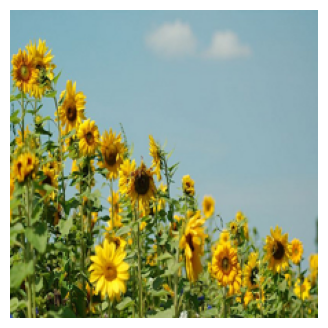

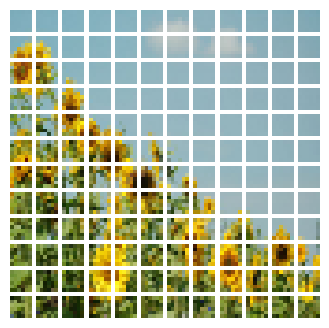

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
image=image_arrays[np.random.choice(range(image_arrays.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]),
    size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch,(patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [15]:
import os
count = 0
base_dir = r'C:\Users\SRI VYSHNAVI\Downloads\Images'
dirs = os.listdir(base_dir)
for dir in dirs:
    dir_path = os.path.join(base_dir, dir)
    if os.path.isdir(dir_path):
        files = os.listdir(dir_path)
        print(f'{dir} Folder has {len(files)} Images')
        count += len(files)
print(f'Images Folder has {count} Images')


daisy Folder has 633 Images
dandelion Folder has 898 Images
roses Folder has 641 Images
sunflowers Folder has 699 Images
tulips Folder has 799 Images
Images Folder has 3670 Images


In [16]:
img_size = 180
batch = 32
patch_size = 6
num_class = 10
input_shapre = (32,32,3)

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

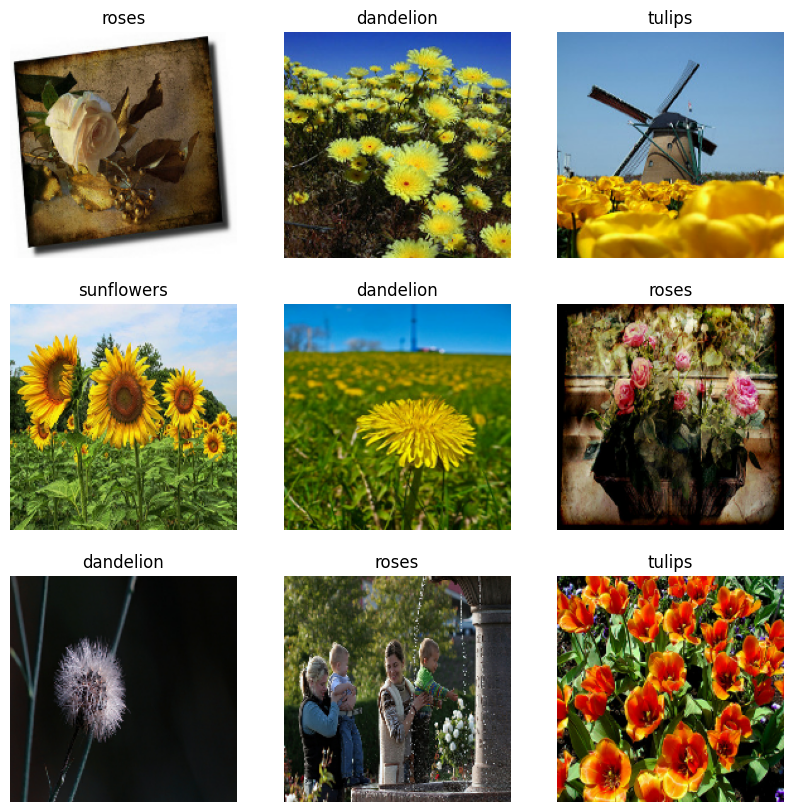

In [18]:
i = 0
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [20]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

c:\Users\SRI VYSHNAVI\OneDrive\Desktop\internship\textClassification\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


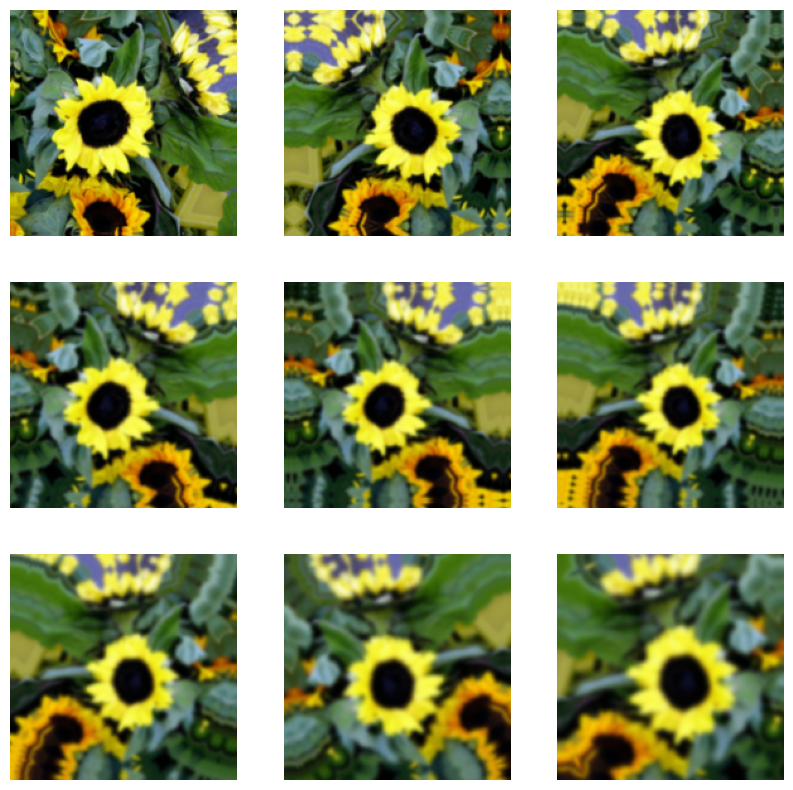

In [21]:
i = 0
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [21]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [23]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.3640 - loss: 1.5665 - val_accuracy: 0.5749 - val_loss: 1.0636
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.5554 - loss: 1.1048 - val_accuracy: 0.6213 - val_loss: 0.9759
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - accuracy: 0.6047 - loss: 0.9968 - val_accuracy: 0.6444 - val_loss: 0.9428
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.6504 - loss: 0.8917 - val_accuracy: 0.6526 - val_loss: 0.9017
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - accuracy: 0.6833 - loss: 0.8433 - val_accuracy: 0.6594 - val_loss: 0.9066
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.7046 - loss: 0.7807 - val_accuracy: 0.7153 - val_loss: 0.7809
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.7172 - loss: 0.7259 - val_accuracy: 0.6839 - val_loss: 0.7948
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.7358 - loss: 0.6840 - val_accu

In [27]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)
    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]),
    size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch,(patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")